<a href="https://colab.research.google.com/github/dmahali1983/Deep-Learning/blob/master/HyperParameterTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

In [2]:
X, y = make_classification(
    n_samples=5000,n_features=2,n_classes=4,n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
X.shape

(5000, 2)

In [3]:
X[:,:]

array([[-0.87561614, -0.97759863],
       [-0.54179887,  1.03863254],
       [-0.71395557, -1.17378147],
       ...,
       [ 2.84190284,  1.41657407],
       [-0.90328423,  1.34882551],
       [-1.44904431,  1.39196208]])

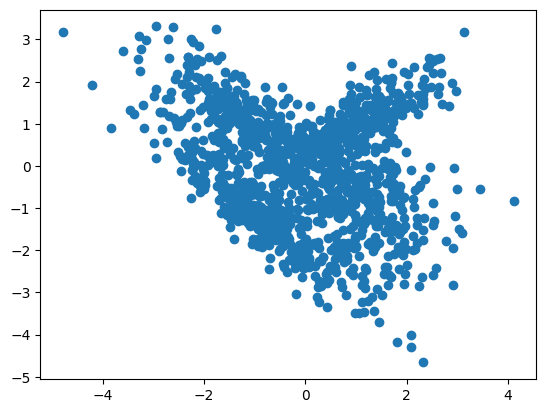

In [4]:
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=12)


plt.scatter(X_test[:,0], X_test[:,1])

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
X_train = torch.from_numpy(np.array(X_train)).float().to(device)
y_train = torch.from_numpy(np.array(y_train)).to(device)

In [7]:
class Net(nn.Module):

  def __init__(self, input_dim = 2, num_classes = 4, num_units = 8, dropout = 0.5, hidden = True):
    super(Net,self).__init__()
    self.fcin = nn.Linear(input_dim, num_units)
    self.fch = nn.Linear(num_units,num_units)
    self.fcout = nn.Linear(num_units, num_classes)
    self.dropout = nn.Dropout(dropout)
    self.act = torch.nn.ReLU()
    self.h = hidden


  def forward(self, x):
    x = self.act(self.fcin(x))
    if self.h:
      x = self.act(self.fch(x))
    x = self.dropout(x)
    x = self.fcout(x)
    return x




In [8]:
train = data_utils.TensorDataset(X_train,y_train)
train_loader = data_utils.DataLoader(train , batch_size=40 , shuffle=True)
criterionCE = nn.CrossEntropyLoss()

def run(model, num_epochs, learning_rate=0.01, bench=True):
  model = model.to(device)

  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

  model.train()

  start = time.time()

  for i in range(0, num_epochs):
    for batch_idx,(data , labels) in enumerate(train_loader):
      data = data.to(device)
      labels = labels.to(device)
      labels = labels.to(torch.int64)
      outputs = model(data)

      loss = criterionCE(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  end = time.time()

  if bench:
    print(f'training completed in {end-start}s')

  return model

In [9]:
def plot_decision(X,y,model,size =(8,8),
                  output_class = False,
                  pt = False, device='cpu',
                  text_pred=False,
                  softmax=False):

  h = .02  # step size in the mesh

  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))

  fig, ax = plt.subplots(figsize=size)

  if pt:
    model.eval()

    input = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float().to(device)
    outputs = model(input)
    if softmax:
      outputs = outputs.data.max(1, keepdim=True)[1]
    Z = outputs.detach().cpu().numpy()


    Xt = torch.from_numpy(X).to(device).float()
    pred = model(Xt)

    if not softmax:
      pred = np.where(pred.detach().cpu().numpy() > 0.5, 1, 0).flatten()
    else:
      pred  =  pred.detach().cpu().numpy().flatten()


  else:

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

  if output_class:
    Z = Z >0.5

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  ax.contourf(xx, yy, Z)
  ax.axis('on')

  # Plot test points
  ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
  if text_pred:
    plt.title(f'pred: {pred}')
  plt.show()

In [10]:
!pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 4.3 MB/s eta 0:00:00


In [19]:
from skorch import NeuralNetClassifier

In [12]:
net = NeuralNetClassifier(Net,  iterator_train__shuffle=True, optimizer=torch.optim.Adam, criterion=nn.CrossEntropyLoss())



In [13]:
net.set_params(train_split=False, verbose=0)

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.Net'>,
)

In [14]:
params = {
    'lr': [0.001, 0.01, 0.02, 0.04, 0.06],
    'max_epochs': [ 20, 40, 80, 90],
    'module__num_units': [16, 32, 64, 128],
    'module__dropout': [0.2,0.6, 0.8],
    'module__input_dim': [2],
    'module__num_classes': [4],
    'module__hidden': [True, False]


}

In [15]:
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=0)

gs.fit(X_train.cpu(), y_train.cpu())
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

best score: 0.835, best params: {'lr': 0.04, 'max_epochs': 90, 'module__dropout': 0.6, 'module__hidden': False, 'module__input_dim': 2, 'module__num_classes': 4, 'module__num_units': 16}


In [16]:
params = gs.best_params_
params

{'lr': 0.04,
 'max_epochs': 90,
 'module__dropout': 0.6,
 'module__hidden': False,
 'module__input_dim': 2,
 'module__num_classes': 4,
 'module__num_units': 16}

In [21]:
from skorch.callbacks import EpochScoring, EarlyStopping, LRScheduler


from torch.optim.lr_scheduler import ReduceLROnPlateau
acc = EpochScoring(scoring='accuracy')

net = NeuralNetClassifier(Net,
    lr = params['lr'],
    max_epochs=params['max_epochs'],
    module__dropout = params['module__dropout'],
    module__num_units = params['module__num_units'],
    module__hidden = params['module__hidden'],
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss(),
    callbacks=[acc])


In [22]:
net

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.Net'>,
  module__dropout=0.6,
  module__hidden=False,
  module__num_units=16,
)

In [23]:
net.fit(X_train, y_train)

  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.8013        0.9119       0.8013        0.5811  0.0702
      2      0.8107        0.7507       0.8107        0.5431  0.0720
      3      0.8107        0.7178       0.8107        0.5404  0.0672
      4      0.8133        0.7243       0.8133        0.5224  0.0721
      5      0.8213        0.7302       0.8213        0.5304  0.0694
      6      0.8240        0.7416       0.8240        0.5177  0.0667
      7      0.8107        0.7191       0.8107        0.5206  0.0688
      8      0.8240        0.7178       0.8240        0.5103  0.0690
      9      0.8200        0.7243       0.8200        0.5215  0.0689
     10      0.8160        0.6994       0.8160        0.5177  0.0672
     11      0.8067        0.7126       0.8067        0.5321  0.0673
     12      0.8267        0.7311       0.8267        0.5169  0.0768
     13      0.8200        0.7341 

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (fcin): Linear(in_features=2, out_features=16, bias=True)
    (fch): Linear(in_features=16, out_features=16, bias=True)
    (fcout): Linear(in_features=16, out_features=4, bias=True)
    (dropout): Dropout(p=0.6, inplace=False)
    (act): ReLU()
  ),
)

In [30]:
class Net(nn.Module):

  def __init__(self, input_dim = 2, num_classes = 4 ,num_units = 8, dropout = 0.5 , hidden = True):
    super(Net, self).__init__()
    self.fcin = nn.Linear(input_dim, num_units)
    self.fchidden = nn.Linear(num_units, num_units)
    self.fcout = nn.Linear(num_units, num_classes)
    self.dropout = nn.Dropout(dropout)
    self.act = nn.ReLU()
    self.h = hidden

  def forward(self, x):

    x = self.act(self.fcin(x))
    if self.h:
      x= self.act(self.fchidden(x))
    x = self.dropout (x)
    x = self.fcout(x)
    return x





In [31]:
net = Net(2 , 4, num_units = params['module__num_units'], dropout = params['module__dropout'] , hidden = params['module__hidden'] )

model = run(net, 60,
            learning_rate=params['lr'],
            bench=False)

In [36]:
def accuracy(model, X, y):
  pred = model(X)
  _, predicted = torch.max(pred.data, 1)
  n_correct = torch.sum(predicted == y)
  total = y.size(0)
  print('Accuracy: %d %%' % (100 * n_correct / total))

X_t= torch.from_numpy(X_test).float().to(device)
y_t = torch.from_numpy(y_test).to(device)

accuracy(model,X_t,y_t)

Accuracy: 72 %


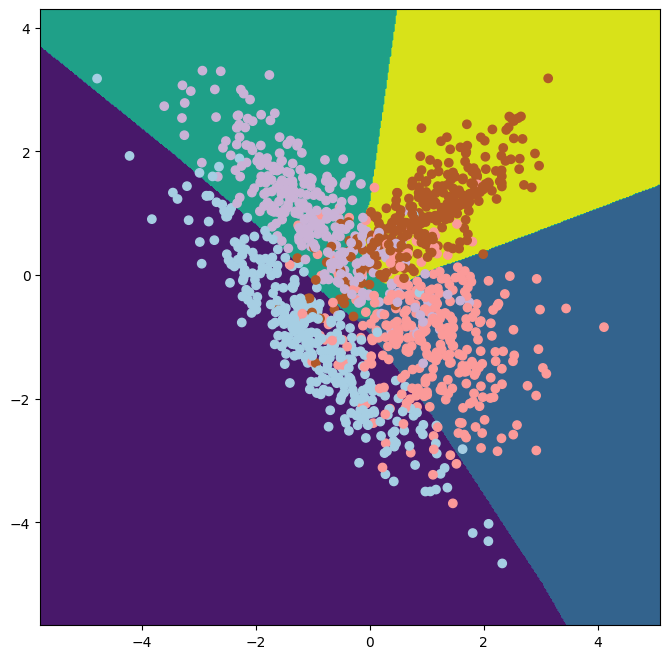

In [38]:
plot_decision(X_t.cpu().numpy(),y_t.cpu().numpy(),model, output_class=False, pt = True, device='cuda', softmax=True)